# Getting Started with the Assistants API

During the public preview, the Assistants API is not available everywhere. Check https://learn.microsoft.com/en-us/azure/ai-services/openai/concepts/models#assistants-preview. I will use Sweden Central.

The API version to use in Azure is 2024-02-15-preview

Let's start creating an Azure OpenAI client...


In [1]:
import os
from dotenv import load_dotenv
from openai import AzureOpenAI

# Load environment variables from .env file
# AZURE_OPENAI_API_KEY
# AZURE_OPENAI_ENDPOINT
# AZURE_OPENAI_API_VERSION
load_dotenv()

# Create Azure OpenAI client
client = AzureOpenAI(
    api_key=os.getenv('AZURE_OPENAI_API_KEY'),
    azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
    api_version=os.getenv('AZURE_OPENAI_API_VERSION')
)


## Creating the assistant

In [3]:
assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="""You are a math tutor that helps users solve math problems. 
    You have access to a sandboxed environment for writing and testing code. 
    Explain to the user why you used the code and how it works
    """,
    tools=[{"type": "code_interpreter"}],
    model="gpt-4" # ensure you have a deployment in the region you are using
)

# display information about the assistant
print(assistant.model_dump_json(indent=2))


{
  "id": "asst_oqoyulQGMfRF0MTRPd5jKdCA",
  "created_at": 1709904901,
  "description": null,
  "file_ids": [],
  "instructions": "You are a math tutor that helps users solve math problems. \n    You have access to a sandboxed environment for writing and testing code. \n    Explain to the user why you used the code and how it works\n    ",
  "metadata": {},
  "model": "gpt-4",
  "name": "Math Tutor",
  "object": "assistant",
  "tools": [
    {
      "type": "code_interpreter"
    }
  ]
}


Above, you can see an assistant has a unique ID. For some reason, you don't see this ID in the Azure OpenAI Playground. With OpenAI, the assistants you create are shown in their portal.

## Creating a thread

Now we can create a thread. A thread is **not linked** to the assistant at creation time

In [4]:
# Create a thread
thread = client.beta.threads.create()

# Threads have an id as well
print("Thread id: ", thread.id)

Thread id:  thread_qCf9vfuqu1lzEE7O05owndnz


## Adding a user question

Now we can add a user question to the thread via a **message**. The message is put on the thread via its ID.

After adding the message, we get the messages from the tread and dump them. Every message has an ID and content. The type of content we add is just text and comes from a user (role=user).

In [5]:
# Add a user question to the thread
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="Solve the equation y = x^2 + 3 for x = 3 and plot the function graph."
)

# Show the messages
thread_messages = client.beta.threads.messages.list(thread.id)
print(thread_messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_AjgTthQI4AeMOen2iFNLyHMr",
      "assistant_id": null,
      "content": [
        {
          "text": {
            "annotations": [],
            "value": "Solve the equation y = x^2 + 3 for x = 3 and plot the function graph."
          },
          "type": "text"
        }
      ],
      "created_at": 1709904928,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "user",
      "run_id": null,
      "thread_id": "thread_qCf9vfuqu1lzEE7O05owndnz"
    }
  ],
  "object": "list",
  "first_id": "msg_AjgTthQI4AeMOen2iFNLyHMr",
  "last_id": "msg_AjgTthQI4AeMOen2iFNLyHMr",
  "has_more": false
}


## Running a thread

Adding a message to a thread does not do much. To get a response from the assistant's model, we need to run the thread.

When you run the thread, you can provide extra instructions via the `instructions` parameter. We do not do that below.

A thread is run asychronously. We need to check the run status to see if it is done. After you run the cell below, keep running the cell under it until the status is `completed`. When it is not completed, the status is `in_progress`.

Other statuses: cancelled, expired, failed

In [6]:
run = client.beta.threads.runs.create(
  thread_id=thread.id,
  assistant_id=assistant.id
)

In [8]:
# run this until the run is completed
# it can take a while before the run is completed
# POZOR: in a real application, create a loop that waits for the run to complete !!!
run = client.beta.threads.runs.retrieve(
  thread_id=thread.id,
  run_id=run.id
)

status = run.status
print(status)

completed


## Result of the run

To see what happened, we have to check the messages of the thread. The user message will be at the bottom. There should be a message with role=assistant. This is the response from the assistant's model. The message has a `content` field with the response. There can be multiple types of responses, for instance text and image.

In [9]:
# dump the messages on the thread again
messages = client.beta.threads.messages.list(
  thread_id=thread.id
)

print(messages.model_dump_json(indent=2))

{
  "data": [
    {
      "id": "msg_If4UmjqvDndXKEtj8cKM83vu",
      "assistant_id": "asst_oqoyulQGMfRF0MTRPd5jKdCA",
      "content": [
        {
          "image_file": {
            "file_id": "assistant-OYBIktLCwJ1mImsvIdsg5wqG"
          },
          "type": "image_file"
        },
        {
          "text": {
            "annotations": [],
            "value": "Here is the graph of the function y = x^2 + 3. As you can see, the function represents a parabola that opens upwards, which is a typical shape for quadratic functions in the form y = ax^2 + bx + c with a > 0. Note that x = 3 (our original input value) falls just on the right side of the parabola's vertex, and at x = 3, y is equal to 12, as we computed earlier."
          },
          "type": "text"
        }
      ],
      "created_at": 1709905011,
      "file_ids": [],
      "metadata": {},
      "object": "thread.message",
      "role": "assistant",
      "run_id": "run_VhaNhfK3PfT2XbNrdEd0V6fW",
      "thread_id": "th

## Showing the response

We can show all messages in the array in reverse order to start from the beginning. Depending on the content (text, image) we can do something with it.

For now just print the text or file_id if there is one

In [10]:
import json

messages_json = json.loads(messages.model_dump_json())

for item in reversed(messages_json['data']):
    # Check the content array
    for content in reversed(item['content']):
        # If there is text in the content array, print it
        if 'text' in content:
            print(content['text']['value'], "\n")
        # If there is an image_file in the content, print the file_id
        if 'image_file' in content:
            print("Image ID:" , content['image_file']['file_id'], "\n")

Solve the equation y = x^2 + 3 for x = 3 and plot the function graph. 

Sure, let's solve it in two steps:

1. Substitute x = 3 into the equation y = x^2 + 3 and solve for y.
2. Plot the function y = x^2 + 3

Let's start with the first step. Here's how we can do that using Python:

```python
x = 3
y = x**2 + 3
```

In Python, `**` is the exponentiation operator, so `x**2` gives x squared. Adding 3 to that gives us our y-value. 

The result is y = 12 when x = 3 in the equation y = x^2 + 3.

Now, let's move on to the second part of the question: plotting the function y = x^2 + 3.

In python, we usually use a package called matplotlib for plotting graphs. We also use numpy to generate an array of x values for which we will compute the corresponding y values.
The code will look something like this:

```python
import matplotlib.pyplot as plt
import numpy as np

x_values = np.linspace(-10, 10, 400)
y_values = x_values**2 + 3

plt.figure(figsize=(6, 6))
plt.plot(x_values, y_values)
plt.title(

## Retrieving the image file

Same code as above but show the image with PIL and IPython.display

Solve the equation y = x^2 + 3 for x = 3 and plot the function graph. 

Sure, let's solve it in two steps:

1. Substitute x = 3 into the equation y = x^2 + 3 and solve for y.
2. Plot the function y = x^2 + 3

Let's start with the first step. Here's how we can do that using Python:

```python
x = 3
y = x**2 + 3
```

In Python, `**` is the exponentiation operator, so `x**2` gives x squared. Adding 3 to that gives us our y-value. 

The result is y = 12 when x = 3 in the equation y = x^2 + 3.

Now, let's move on to the second part of the question: plotting the function y = x^2 + 3.

In python, we usually use a package called matplotlib for plotting graphs. We also use numpy to generate an array of x values for which we will compute the corresponding y values.
The code will look something like this:

```python
import matplotlib.pyplot as plt
import numpy as np

x_values = np.linspace(-10, 10, 400)
y_values = x_values**2 + 3

plt.figure(figsize=(6, 6))
plt.plot(x_values, y_values)
plt.title(

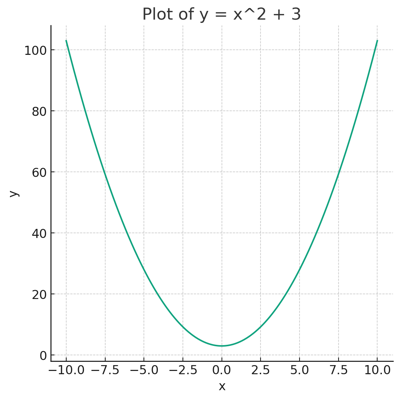

In [11]:
from PIL import Image
from IPython.display import display

for item in reversed(messages_json['data']):
    # Check the content array
    for content in reversed(item['content']):
        # If there is text in the content array, print it
        if 'text' in content:
            print(content['text']['value'], "\n")
        # If there is an image_file in the content, print the file_id
        if 'image_file' in content:
            file_id = content['image_file']['file_id']
            file_content = client.files.content(file_id)
            # use PIL with the file_content
            img = Image.open(file_content)
            img = img.resize((400, 400))
            display(img)
            
            


## Ask another question

We can add another user message to the thread and run it again. But now, we will wait for the response and display it right away.

We will use Markdown to display the assistant's response.

The new_run function is a helper function to add a question 

Status: completed


Solve the equation y = x^2 + 3 for x = 3 and plot the function graph.

Sure, let's solve it in two steps:

1. Substitute x = 3 into the equation y = x^2 + 3 and solve for y.
2. Plot the function y = x^2 + 3

Let's start with the first step. Here's how we can do that using Python:

```python
x = 3
y = x**2 + 3
```

In Python, `**` is the exponentiation operator, so `x**2` gives x squared. Adding 3 to that gives us our y-value.

The result is y = 12 when x = 3 in the equation y = x^2 + 3.

Now, let's move on to the second part of the question: plotting the function y = x^2 + 3.

In python, we usually use a package called matplotlib for plotting graphs. We also use numpy to generate an array of x values for which we will compute the corresponding y values.
The code will look something like this:

```python
import matplotlib.pyplot as plt
import numpy as np

x_values = np.linspace(-10, 10, 400)
y_values = x_values**2 + 3

plt.figure(figsize=(6, 6))
plt.plot(x_values, y_values)
plt.title('Plot of y = x^2 + 3')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()
```

The numpy method linspace generates an array of 400 values from -10 to 10 (inclusive). For each of these x values, we compute the corresponding y value (x^2 + 3).

Then, we use various matplotlib.pyplot methods to generate the plot. The 'figure' method creates a new figure, 'plot' generates the plot, 'title', 'xlabel', and 'ylabel' add a title and labels to the plot, 'grid' adds a grid, and 'show' displays the plot.

Here is the graph of the function y = x^2 + 3. As you can see, the function represents a parabola that opens upwards, which is a typical shape for quadratic functions in the form y = ax^2 + bx + c with a > 0. Note that x = 3 (our original input value) falls just on the right side of the parabola's vertex, and at x = 3, y is equal to 12, as we computed earlier.

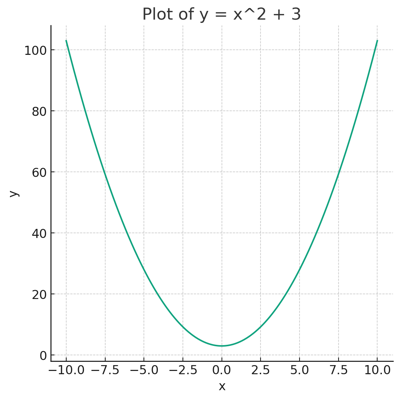

Is this a concave function?

Yes, the function y = x^2 + 3 is a concave-up function. 

In mathematics, a function is said to be concave up on an interval if the line segment between any two points on the graph of the function lies above or on the graph. 

For quadratic functions, a simpler way to determine whether it's concave up or down is to look at the coefficient of the x^2 term. If that coefficient is positive, like in our case (where the coefficient is 1), the function is concave up. If that coefficient were negative, the function would be concave down.

The concavity of a function can be visually confirmed by its graph. As shown in the plot of our function y = x^2 + 3, the function's graph opens upwards, which characterizes a concave-up function.

In [12]:
from IPython.display import clear_output, display, Markdown
import time

def new_run(question, thread_id):

    # add new message to the thread
    message = client.beta.threads.messages.create(
        thread_id=thread_id,
        role="user",
        content=question
    )

    # run the tread again
    run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id
    )

    status = run.status

    while status not in ["completed", "cancelled", "expired", "failed"]:
        time.sleep(2)
        run = client.beta.threads.runs.retrieve(thread_id=thread.id,run_id=run.id)
        status = run.status
        print(f'Status: {status}')
        clear_output(wait=True)

    print(f'Status: {status}')

    messages = client.beta.threads.messages.list(
        thread_id=thread.id
    )

    messages_json = json.loads(messages.model_dump_json())

    for item in reversed(messages_json['data']):
        # Check the content array
        for content in reversed(item['content']):
            # If there is text in the content array, print it as Markdown
            if 'text' in content:
                display(Markdown(content['text']['value']))
            # If there is an image_file in the content, print the file_id
            if 'image_file' in content:
                file_id = content['image_file']['file_id']
                file_content = client.files.content(file_id)
                # use PIL with the file_content
                img = Image.open(file_content)
                img = img.resize((400, 400))
                display(img)

new_run("Is this a concave function?", thread.id)

In [13]:
# create a new thread and run
thread = client.beta.threads.create()
new_run("If a woman has two kids of 5 and 7 and she is 33, how many years does it take for the age of the two children to be exactly half her age", thread.id)

Status: completed


If a woman has two kids of 5 and 7 and she is 33, how many years does it take for the age of the two children to be exactly half her age

In order for the combined age of the children to be half the mother's age, we need to set up an equation. We can denote the number of years it takes as "y". Our equation is:

(33 + y) / 2 = 5 + y + 7 + y

This equation states that the mother's age plus the number of years, divided by 2, is equal to the starting age of the first child plus the number of years, added to the starting age of the second child plus the number of years. 

To calculate "y", it's simple algebra. Let me quickly run the code to compute the result.

It will take 3 years for the combined age of the two children to be exactly half of the mother's age.

Here is how the calculation works:
In our equation, we express the condition that half of the mother's age (this increases by one every year) is equal to the total age of her two kids (this increases by two every year because each child gets one year older). 
In other words, every year the difference between half of the mother's age and the total age of her kids decreases by 0.5 years. 

At the beginning (when the mother is 33 years old), the difference is (33 / 2) - (5 + 7) = 16.5 - 12 = 4.5 years. Since this difference decreases by 0.5 years each year, it will take 4.5 / 0.5 = 9 years for it to become 0. 

But we need the kids' total age to be exactly half the mother's age, not less by half (which means the difference is -0.5), so it's 9 years - 6 years = 3 years. 

So, the correct answer is 3 years.